In [4]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from scipy.signal import detrend
import pandas as pd
from datetime import datetime
from eofs.xarray import Eof

In [5]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45105 instead
  warnings.warn(


In [6]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1950-01-01", "2022-12-31"))
hadsst = hadsst.compute()

In [7]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [8]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [9]:
hadsst1 = roll_lon(hadsst1)

In [51]:
def ssta(DS):
    #clim = DS.sel(time = slice("1990-01-01", "2005-12-31")).groupby('time.month').mean('time')
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34_sst(DS):
    return (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
def NINO3(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(210, 270)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(190, 240)).mean(['latitude', 'longitude'])
def NINO4(DS):
    return ssta(DS).sel(latitude=slice(
         -5, 5),longitude=slice(160, 210)).mean(['latitude', 'longitude'])
def DMI(DS):
    WTIO =  ssta(DS).sel(latitude=slice(
         -10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO =  ssta(DS).sel(latitude=slice(
         -10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return (WTIO - SETIO)

In [11]:
def Modoki(DS):
    boxa = ssta(DS).sel(latitude=slice(
        -10, 10),longitude=slice(165, 220)).mean(['latitude', 'longitude'])
    boxb = ssta(DS).sel(latitude=slice(
        -15, 5),longitude=slice(250, 290)).mean(['latitude', 'longitude'])
    boxc = ssta(DS).sel(latitude=slice(
        -10, 20),longitude=slice(125, 145)).mean(['latitude', 'longitude'])
    return (boxa - (0.5*boxb) - (0.5*boxc))

In [46]:
def EP_CP_index(DS):
    """
    Calculate the Eastern Pacific (EP) and Central Pacific (CP) indices 
    based on the first two principal components (PCs) from an EOF analysis 
    of sea surface temperature anomalies (SSTAs), with adjustments based 
    on the sign of the EOFs at a specific location (250° longitude, 0° latitude).

    The function first computes the SST anomalies over a specified region 
    (140° to 280° longitude, -15° to 15° latitude) and then performs an EOF analysis.
    The sign of the first two EOFs at the specified location is used to adjust
    the sign of the corresponding PCs. The EP and CP indices are then calculated 
    from these adjusted PCs.

    Parameters:
    -----------
    DS : xarray.Dataset
        A dataset containing sea surface temperature data. The dataset should 
        include 'xt_ocean' and 'yt_ocean' coordinates.

    Returns:
    --------
    tuple of xarray.DataArray
        A tuple containing the EP and CP indices as xarray.DataArray objects.

    Notes:
    ------
    - The function assumes that the input dataset 'DS' has the necessary 
      fields and coordinates for the EOF analysis.
    - The SST anomaly is calculated internally within the function; 
      hence, 'DS' should contain absolute SST values.
    - The function uses the 'eofs.xarray' package for EOF analysis.
    - The weights for the EOF analysis are calculated as the square root 
      of the cosine of latitude.

    Example:
    --------
    >>> ds = xr.open_dataset('sst_data.nc')
    >>> ep_index, cp_index = EP_CP_index(ds)
    >>> print(ep_index, cp_index)
    """
    # Compute SST anomaly and select region
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude=slice(140, 280), latitude=slice(-15, 15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]

    # EOF analysis
    solver = Eof(sst_anom, weights=wgts)
    pcs = solver.pcs(npcs=2, pcscaling=1)

    # Calculate EOFs
    eofs_ = solver.eofsAsCovariance(neofs=4)
    
    # Check sign of EOFs at specific location
    eof1_val = eofs_.sel(mode=0, longitude=250, latitude=0, method="nearest").values
    eof2_val = eofs_.sel(mode=1, longitude=250, latitude=0, method="nearest").values

    # Adjust PCs based on EOF sign
    if eof1_val < 0:
        pc1= -pcs[:, 0]
    else:
        pc1 = pcs[:, 0]
    if eof2_val < 0:
        pc2 = pcs[:, 1]
    else:
        pc2 = -pcs[:, 1]

    # Calculate indices
    EP = (pc1 - pc2) / np.sqrt(2)
    CP = (pc1 + pc2) / np.sqrt(2)

    return EP, CP


In [13]:
def EPI_CPI(DS):
    #define Nino3 and Nino4
    n3 = NINO3(DS)
    n4 = NINO4(DS)
    alpha = xr.where(n3 * n4 > 0, 0.4, 0)

    # Calculate EPI and CPI
    EPI = n3 - alpha * n4
    CPI = n4 - alpha * n3
    return EPI, CPI


In [14]:
def EP_CP_events(DS):
    EP, CP = EP_CP_index(DS)
    # Select SON seasons into a timeseries
    E_DJF = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    C_DJF = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    #get the Ep and CP events
    TH_E = E_DJF.std()
    EP_e = E_DJF.where(E_DJF >1* TH_E.values).dropna(dim="time")
    TH_C = C_DJF.std()
    CP_e = C_DJF.where(C_DJF >1* TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [15]:
def EPI_CPI_events(DS):
    EPI, CPI = EPI_CPI(DS)
    # Select SON seasons into a timeseries
    E_SON = EPI.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    C_SON = CPI.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"]
    #get the Ep and CP events
    TH_E = 0.6*E_SON.std()
    EP_e = E_SON.where(E_SON > TH_E.values).dropna(dim="time")
    TH_C = 0.6*C_SON.std()
    CP_e = C_SON.where(C_SON > TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [16]:
def KUG_events(DS):
    #calculate N3 and N4 index
    n3 = NINO3(DS)
    n4 = NINO4(DS)
    #standardise
    n3 = n3/abs(n3).max()
    n4 = n4/abs(n4).max()
    # go to Quarterly timesiers
    n3 = n3.resample(time='QS-DEC').mean(dim="time")
    n4 = n4.resample(time='QS-DEC').mean(dim="time")
    # Select DJF seasons into a timeseries
    n3DJF = n3.groupby('time.season')["DJF"]
    n4DJF = n4.groupby('time.season')["DJF"]
    # Initialize lists to hold the indices of WP and CT El Nino events
    wp_el_nino_events = []
    ct_el_nino_events = []

    # Iterate over the time dimension
    for t in n3DJF.time:
    # Check for WP El Nino condition
        if n4DJF.sel(time = t) > n4.std() and n4DJF.sel(time = t) > n3DJF.sel(time = t):
            wp_el_nino_events.append(t)

        # Check for CT El Nino condition
        if n3DJF.sel(time = t) > n3.std() and n3DJF.sel(time = t) > n4DJF.sel(time = t):
            ct_el_nino_events.append(t)

    return xr.concat(wp_el_nino_events, dim = "time").groupby('time.year').mean("time").year, xr.concat(ct_el_nino_events, dim = "time").groupby('time.year').mean("time").year
    

In [17]:
EP, CP =  EP_CP_index(hadsst1)


In [18]:
#use EP CP method to get composiste and regression plots

In [19]:
E_yrs, C_yrs = EP_CP_events(hadsst1)

In [20]:
C_yrs

<xarray.DataArray 'year' (year: 13)>
array([1957, 1968, 1979, 1987, 1990, 1994, 2002, 2004, 2009, 2014, 2015, 2018,
       2019])
Coordinates:
  * year     (year) int64 1957 1968 1979 1987 1990 ... 2009 2014 2015 2018 2019

In [21]:
E_yrs

<xarray.DataArray 'year' (year: 8)>
array([1965, 1972, 1976, 1982, 1986, 1991, 1997, 2015])
Coordinates:
  * year     (year) int64 1965 1972 1976 1982 1986 1991 1997 2015

In [28]:
sst_anoms = ssta(hadsst1)
sst_anoms_djf = sst_anoms.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"].groupby("time.year").mean("time")
sst_anoms_son = sst_anoms.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"].groupby("time.year").mean("time")

In [29]:
ep_djf_comp = sst_anoms_djf.where(sst_anoms_djf.year == E_yrs).mean("year")
cp_djf_comp = sst_anoms_djf.where(sst_anoms_djf.year == C_yrs).mean("year")

In [30]:
ep_son_comp = sst_anoms_son.where(sst_anoms_son.year == E_yrs).mean("year")
cp_son_comp = sst_anoms_son.where(sst_anoms_son.year == C_yrs).mean("year")

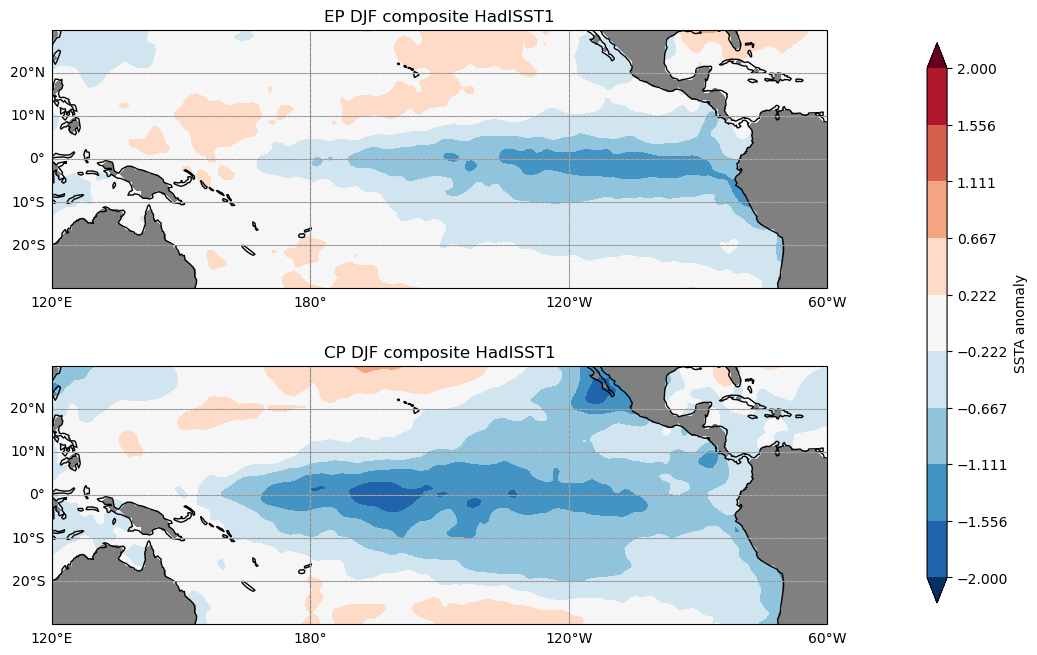

In [31]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = ep_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("EP DJF composite HadISST1")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = cp_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("CP DJF composite HadISST1")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(cf, cax=cbar_ax)
cbar.set_label('SSTA anomaly')

#plt.tight_layout()
plt.show()

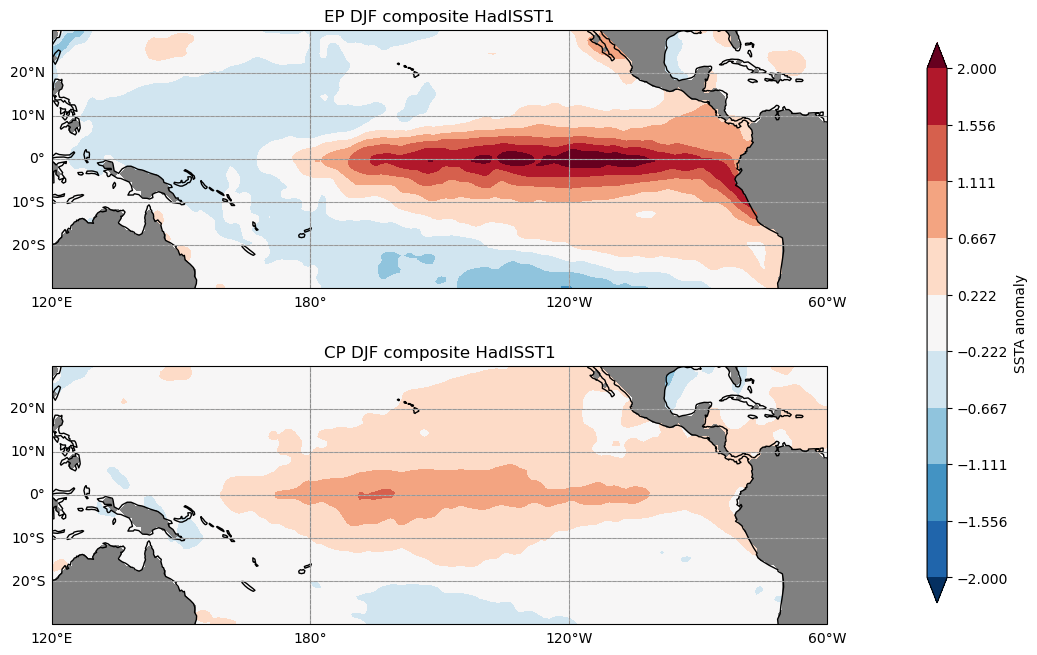

In [30]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = ep_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("EP DJF composite HadISST1")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = cp_djf_comp.plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-2, vmax=2, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("CP DJF composite HadISST1")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(cf, cax=cbar_ax)
cbar.set_label('SSTA anomaly')

#plt.tight_layout()
plt.show()

In [24]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [25]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['year'], ['year']],# reduce along 'model'
                        )
    return slope

In [22]:
CP_DJF = CP.resample(
    time='QS-DEC').mean(
    dim="time").groupby('time.season')["DJF"].groupby(
    "time.year").mean("time")

In [23]:
EP_DJF = EP.resample(
    time='QS-DEC').mean(
    dim="time").groupby('time.season')["DJF"].groupby(
    "time.year").mean("time")

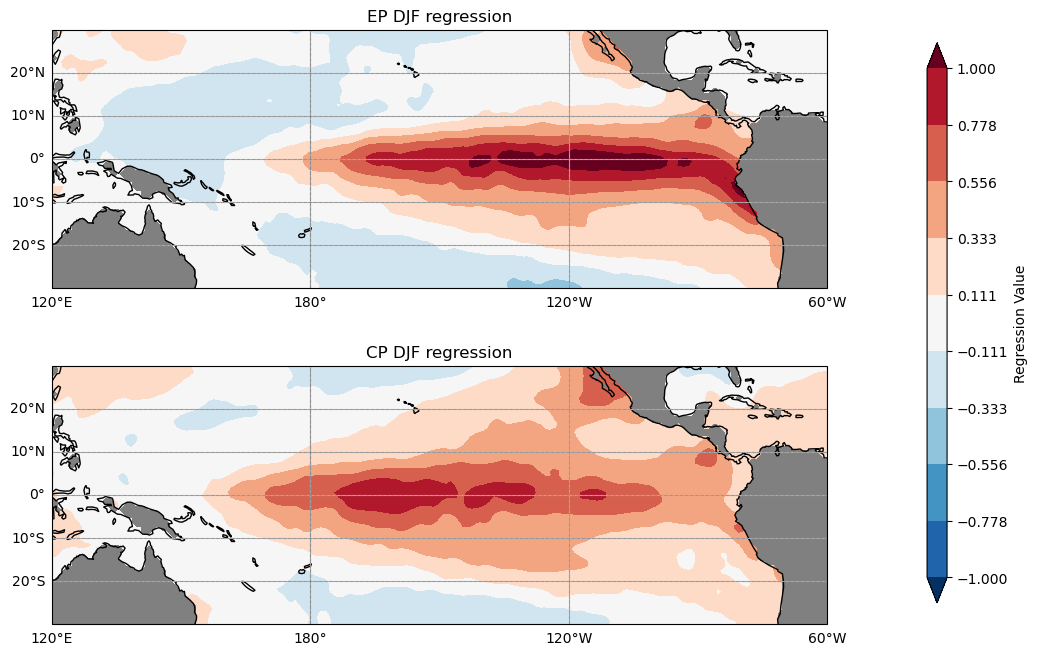

In [26]:
# Create figure with 2x2 grid of subplots
fig = plt.figure(figsize=(10, 8))

# Create a list to store the contourf objects for each subplot
contourf_objs = []

ax = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = regress(EP_DJF,sst_anoms_djf).plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("EP DJF regression")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree(central_longitude=180))
    
# Calculate the regression and plot it with contourf
cf = regress(CP_DJF,sst_anoms_djf).plot.contourf(transform=ccrs.PlateCarree(),
                        vmin=-1, vmax=1, levels=10, extend='both', cmap="RdBu_r", ax=ax, add_colorbar = False)

plt.title("CP DJF regression")
ax.coastlines(color='k')
ax.gridlines()
ax.set_facecolor('grey')
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Create a single colorbar for all subplots
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
cbar = plt.colorbar(cf, cax=cbar_ax)
cbar.set_label('Regression Value')

#plt.tight_layout()
plt.show()

In [26]:
def monthly_evo(TS1, TS2):
    TS1m = TS1.groupby("time.month").mean("time")
    TS2m = TS2.groupby("time.month").mean("time").assign_coords({"month":[13,14,15,16,17,18,19,20,21,22,23,24]})
    TS3 = xr.concat([TS1m, TS2m], dim = "month")
    JF0 = TS3.sel(month = slice(1,2)).mean("month").expand_dims({"season":["JF(0)"]})
    MAM0 = TS3.sel(month = slice(3,5)).mean("month").expand_dims({"season":["MAM(0)"]})
    JJA0 = TS3.sel(month = slice(6,8)).mean("month").expand_dims({"season":["JJA(0)"]})
    SON0 = TS3.sel(month = slice(9,11)).mean("month").expand_dims({"season":["SON(0)"]})
    D0JF1 = TS3.sel(month = slice(12,14)).mean("month").expand_dims({"season":["D(0)JF(1)"]})
    MAM1 = TS3.sel(month = slice(15,17)).mean("month").expand_dims({"season":["MAM(1)"]})
    JJA1 = TS3.sel(month = slice(18,20)).mean("month").expand_dims({"season":["JJA(1)"]})
    SON1 = TS3.sel(month = slice(21,23)).mean("month").expand_dims({"season":["SON(1)"]})
    D1 = TS3.sel(month = 24).expand_dims({"season":["D(1)"]})


    TS4 = xr.concat([JF0, MAM0, JJA0, SON0, D0JF1, MAM1, JJA1, SON1,D1], dim = "season")
    
    return TS4

In [27]:
def get_EPCP_times(ds_sst, ds_var=None):

    EP, CP = EP_CP_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    EP_E = EP
    CP_E = CP
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ssta(ds_sst)
    
        
    # Initialize empty lists to store subsets
    epos_list = []
    epos_list2 = []
    cpos_list = []
    cpos_list2 = []    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in EP_E:
                pos_subset = group
                epos_list.append(pos_subset)
                epos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in CP_E:
                pos_subset = group
                cpos_list.append(pos_subset)
                cpos_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries", year)
    
    # Concatenate subsets into a single DataArray
    esubset_ds_pos = xr.concat(epos_list, dim='time')
    esubset_ds_pos2 = xr.concat(epos_list2, dim='time')
    
    csubset_ds_pos = xr.concat(cpos_list, dim='time')
    csubset_ds_pos2 = xr.concat(cpos_list2, dim='time')
     
    
    #now convert these to means and composite evolutions
    EP_E12 = monthly_evo(esubset_ds_pos, esubset_ds_pos2)

    CP_E12 = monthly_evo(csubset_ds_pos, csubset_ds_pos2)

    
    return EP_E12, CP_E12,esubset_ds_pos

In [48]:
EP12, CP12, test = get_EPCP_times(hadsst1)

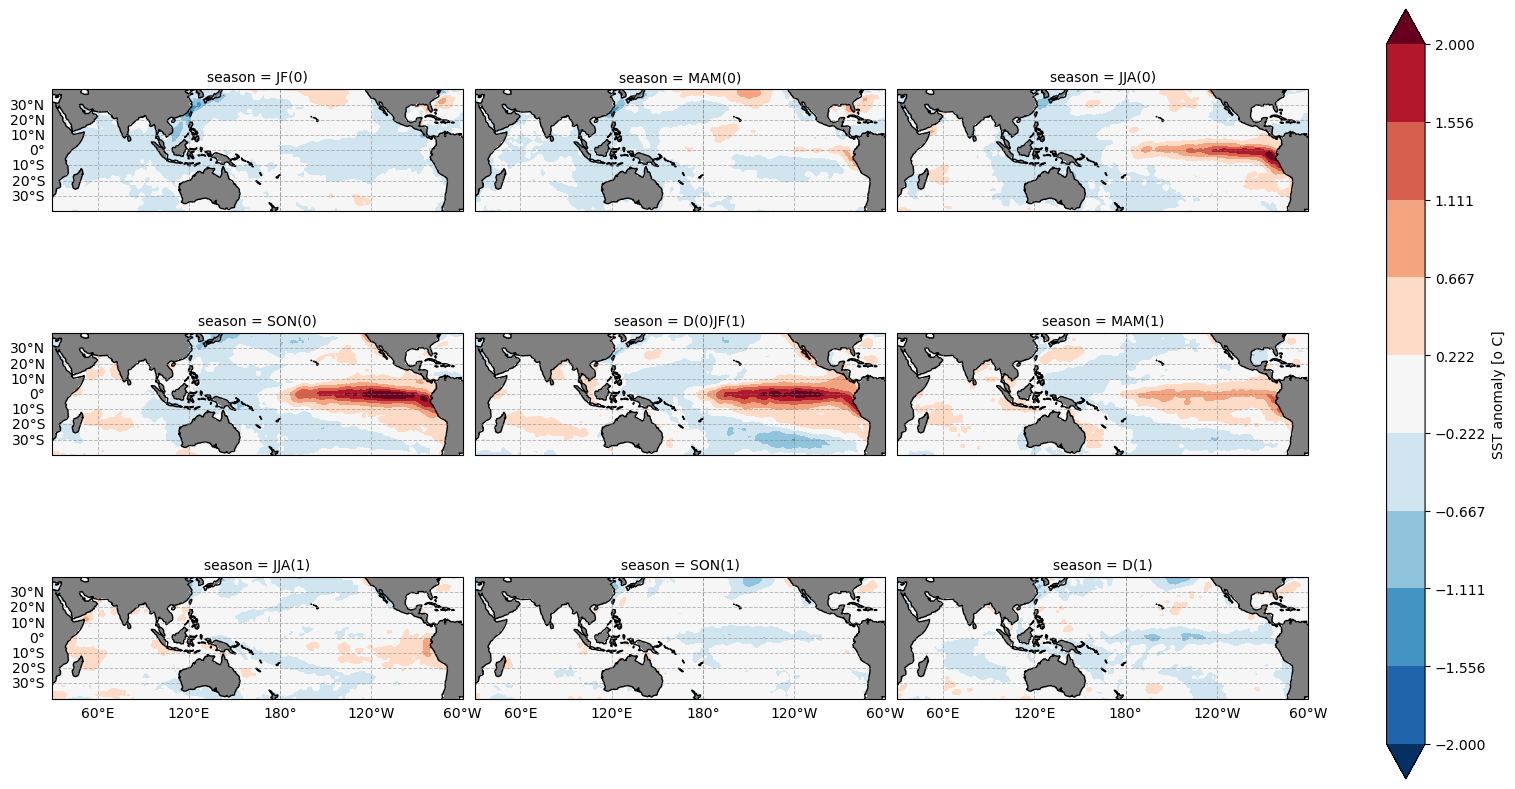

In [49]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = EP12.plot.contourf(col="season", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

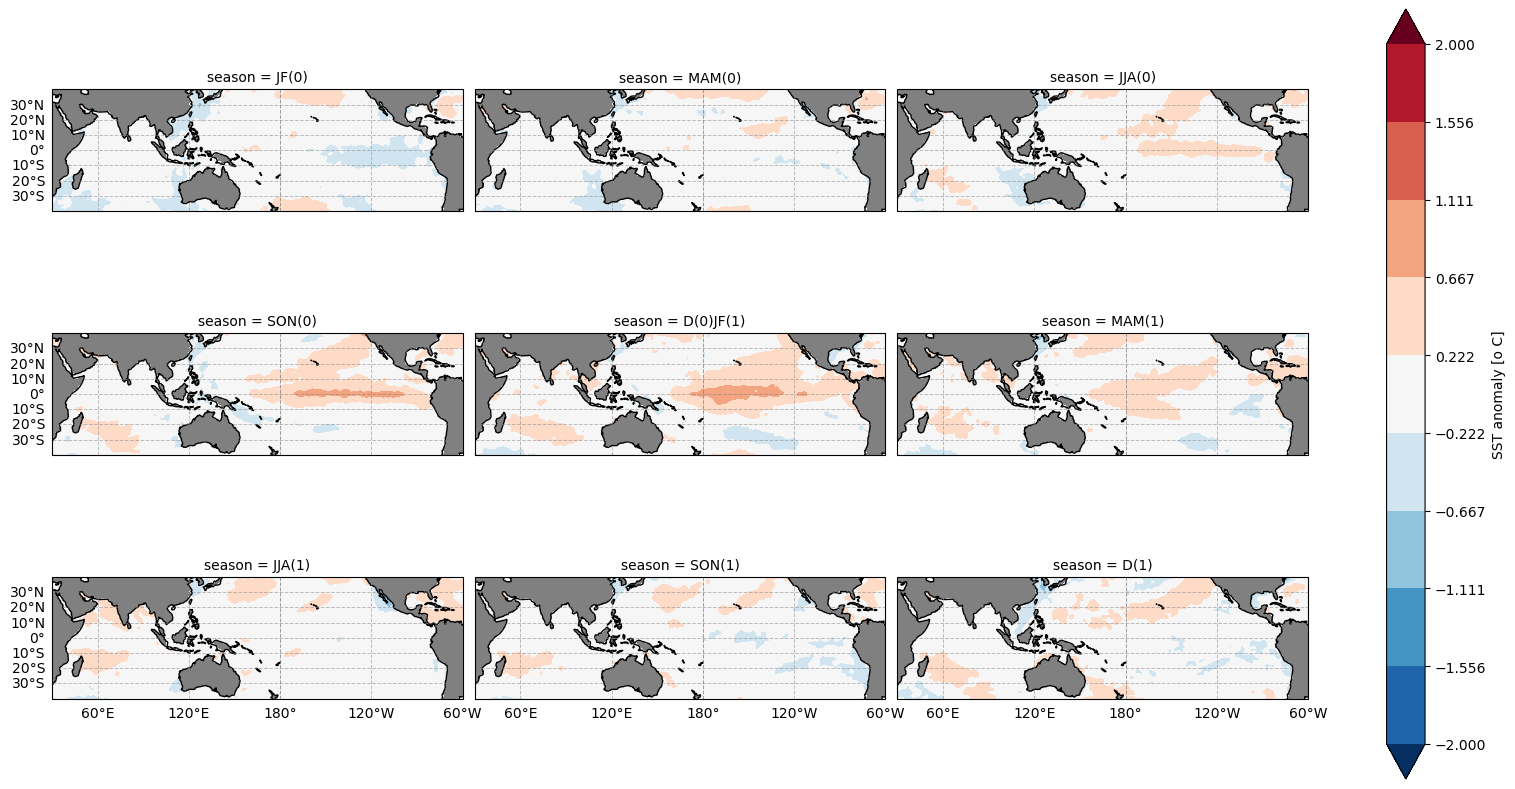

In [50]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = CP12.plot.contourf(col="season", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [31]:
#load in ctrl dataset
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl = ctrl_sst.sst.compute()

In [32]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [33]:
ctrl = roll_lon(ctrl)

In [40]:
ctrl = ctrl.rename({"xt_ocean":"longitude", "yt_ocean":"latitude"})

In [55]:
ctrl = ctrl.drop({"geolat_t","geolon_t"})

In [56]:
EP12, CP12, test = get_EPCP_times(ctrl)

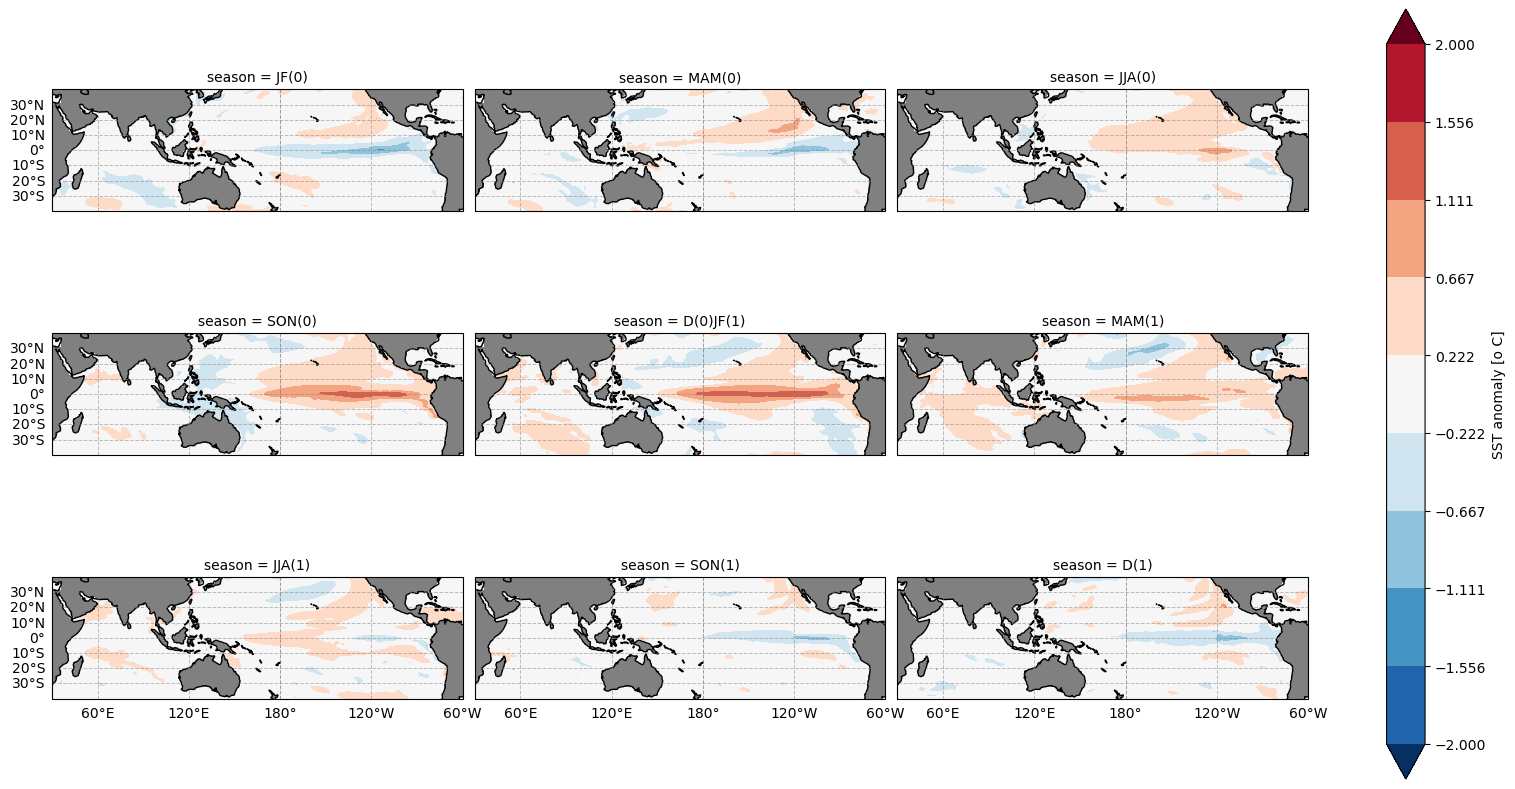

In [57]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = CP12.plot.contourf(col="season", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

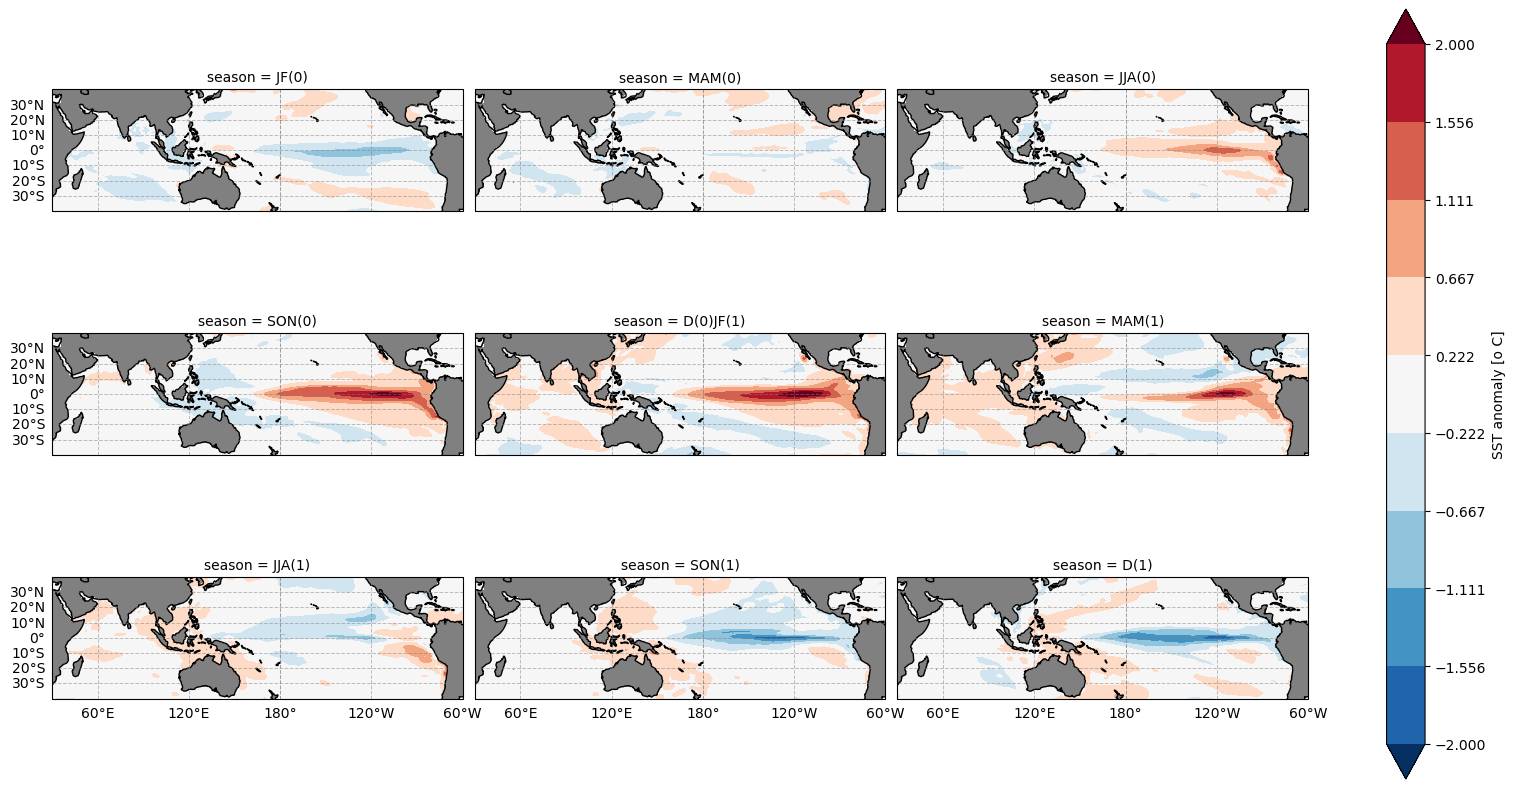

In [58]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = EP12.plot.contourf(col="season", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

In [16]:
#aaply butterworth filter

In [62]:
from scipy.signal import butter, filtfilt

In [18]:
#perfrom on SSTA

In [19]:
n3 = NINO3(hadsst1)

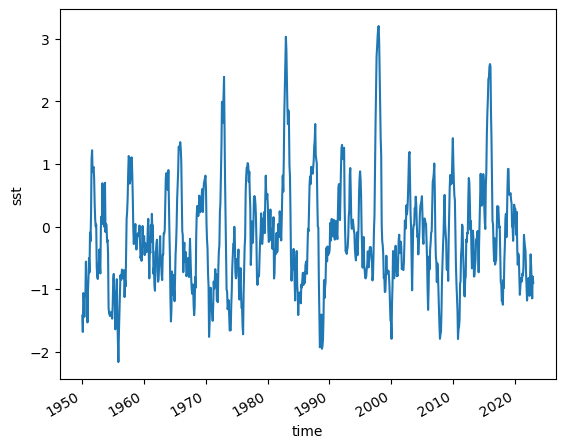

In [20]:
n3.plot()

In [21]:
from scipy import signal

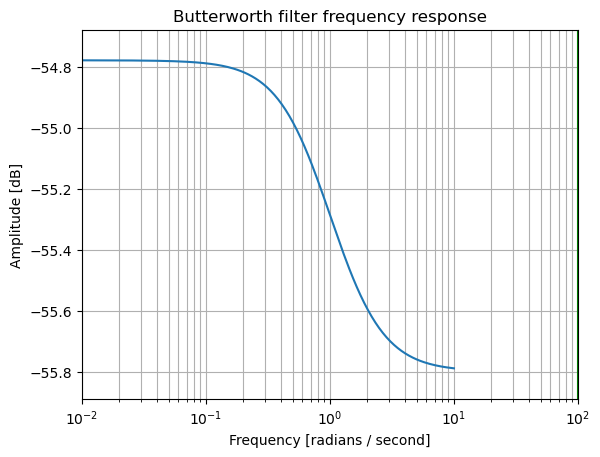

In [24]:
b, a = signal.butter(2, [1/120,1/6], 'band', fs = 12)
w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Butterworth filter frequency response')

plt.xlabel('Frequency [radians / second]')

plt.ylabel('Amplitude [dB]')

plt.margins(0, 0.1)

plt.grid(which='both', axis='both')

plt.axvline(100, color='green') # cutoff frequency

plt.show()

In [32]:
sampling_rate = 12
# Define the frequency range for the Butterworth filter
low_cut = 1/0.5
high_cut = 1/10

# Normalize the frequencies by the Nyquist frequency (half the sampling rate)
nyquist = 0.5 * sampling_rate
low = low_cut / nyquist
high = high_cut / nyquist

# Design the Butterworth bandpass filter
b, a = butter(N=2, Wn=[high,low], btype='band')

# Apply the filter
filtered_data = filtfilt(b, a, n3.values)

# Convert the filtered signal back to xarray DataArray (if needed)
filtered_xarray = xr.DataArray(filtered_data, dims=n3.dims, coords=n3.coords)


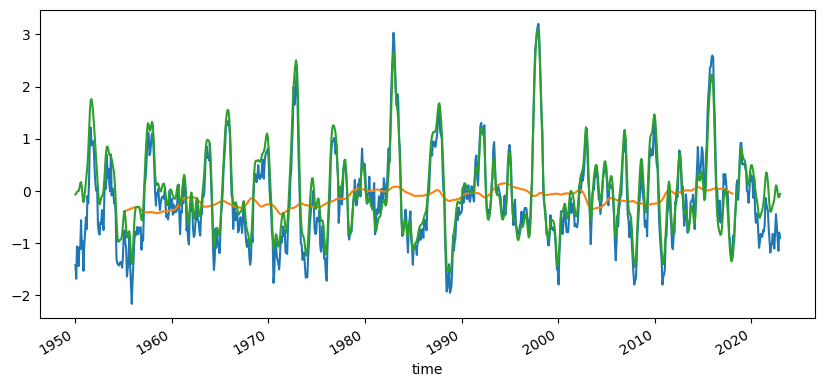

In [38]:
n3.plot(figsize = (10, 4))
n3.rolling(time=120, center=True).mean('time').plot()
filtered_xarray.plot()

In [34]:
# Define the sampling rate
# For monthly data, the sampling rate is 12 samples per year
sampling_rate = 1

# Define the frequency range for the Butterworth filter (6-120 months)
low_cut = 1 / 120  # 1 divided by 120 months
high_cut = 1 / 6   # 1 divided by 6 months

# Normalize the frequencies by the Nyquist frequency (half the sampling rate)
nyquist = 0.5 * sampling_rate
low = low_cut / nyquist
high = high_cut / nyquist

# Design the Butterworth bandpass filter
b, a = butter(N=2, Wn=[low, high], btype='band')

# Apply the filter
filtered_data = filtfilt(b, a, ssta(hadsst1), axis = 0)

# Convert the filtered signal back to xarray DataArray (if needed)
filtered_xarray1 = xr.DataArray(filtered_data, dims=hadsst1.dims, coords=hadsst1.coords)

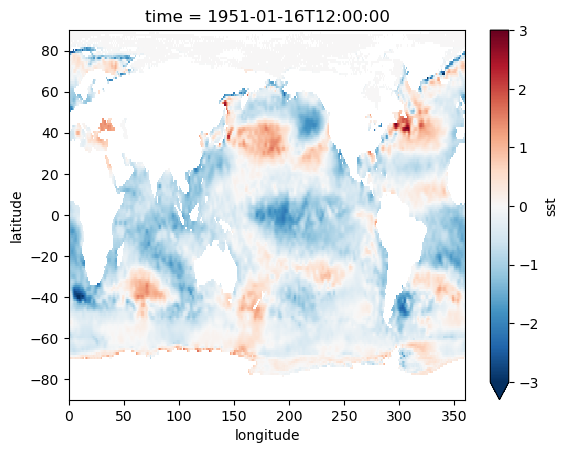

In [59]:
ssta(hadsst1)[12].plot(vmin = -3)

In [63]:
def apply_butterworth_filter(data, low_cut, high_cut, sampling_rate):
    """
    Applies a Butterworth bandpass filter to the given data. Works on 3d data like SST

    Parameters:
    data (xarray.DataArray): The input data to be filtered.
    low_cut (float): The lower frequency bound for the filter (in 1/months).
    high_cut (float): The upper frequency bound for the filter (in 1/months).
    sampling_rate (int): The sampling rate of the data (in samples per year).

    Returns:
    xarray.DataArray: The filtered data as an xarray DataArray.
    """
    # Normalize the frequencies by the Nyquist frequency (half the sampling rate)
    nyquist = 0.5 * sampling_rate
    low = low_cut / nyquist
    high = high_cut / nyquist

    # Design the Butterworth bandpass filter
    b, a = butter(N=2, Wn=[low, high], btype='band')

    # Apply the filter
    filtered_data = filtfilt(b, a, data, axis=0)

    # Convert the filtered signal back to xarray DataArray
    return xr.DataArray(filtered_data, dims=data.dims, coords=data.coords)

In [64]:
# Example usage
sampling_rate = 1
low_cut = 1 / 120  # 1 divided by 120 months
high_cut = 1 / 6   # 1 divided by 6 months

# Assuming hadsst1 is an existing xarray DataArray
had_ssta_filt = apply_butterworth_filter(ssta(hadsst1), low_cut, high_cut, sampling_rate)

In [65]:
WP, CT = KUG_events(hadsst1)

In [66]:
WP

<xarray.DataArray 'year' (year: 6)>
array([1957, 1968, 1994, 2009, 2014, 2019])
Coordinates:
  * year     (year) int64 1957 1968 1994 2009 2014 2019

In [67]:
CT

<xarray.DataArray 'year' (year: 7)>
array([1965, 1972, 1982, 1986, 1991, 1997, 2015])
Coordinates:
  * year     (year) int64 1965 1972 1982 1986 1991 1997 2015

In [68]:
EPI, CPI = EPI_CPI_events(hadsst1)

In [69]:
EPI

<xarray.DataArray 'year' (year: 15)>
array([1951, 1957, 1963, 1965, 1969, 1972, 1976, 1979, 1982, 1987, 1997, 2002,
       2006, 2009, 2015])
Coordinates:
  * year     (year) int64 1951 1957 1963 1965 1969 ... 1997 2002 2006 2009 2015

In [70]:
CPI

<xarray.DataArray 'year' (year: 8)>
array([1977, 1987, 1994, 2002, 2004, 2009, 2018, 2019])
Coordinates:
  * year     (year) int64 1977 1987 1994 2002 2004 2009 2018 2019

In [75]:
EP, CP = EP_CP_events(hadsst1)

In [76]:
CP

<xarray.DataArray 'year' (year: 13)>
array([1957, 1968, 1979, 1987, 1990, 1994, 2002, 2004, 2009, 2014, 2015, 2018,
       2019])
Coordinates:
  * year     (year) int64 1957 1968 1979 1987 1990 ... 2009 2014 2015 2018 2019

In [77]:
EP

<xarray.DataArray 'year' (year: 8)>
array([1965, 1972, 1976, 1982, 1986, 1991, 1997, 2015])
Coordinates:
  * year     (year) int64 1965 1972 1976 1982 1986 1991 1997 2015

In [78]:
#lets make a DJF composite of SSTA for all these events and see what it looks like

In [81]:
SST_anom = had_ssta_filt
#get DJF 
SST_anom = SST_anom.resample(time='QS-DEC').mean(dim="time")
#SST_anom = SST_anom.groupby('time.season')["SON"].groupby('time.year').mean('time')

In [82]:
SST_anom_SON = SST_anom.groupby('time.season')["SON"].groupby('time.year').mean('time')
SST_anom_DJF = SST_anom.groupby('time.season')["DJF"].groupby('time.year').mean('time')

In [65]:
xr.DataArray([1977,1986,1990,1991,1994,2002,2004,2009], dims=["year"],coords=dict(

        year=(["year"], [1977,1986,1990,1991,1994,2002,2004,2009])))

<xarray.DataArray (year: 8)>
array([1977, 1986, 1990, 1991, 1994, 2002, 2004, 2009])
Coordinates:
  * year     (year) int64 1977 1986 1990 1991 1994 2002 2004 2009

In [83]:
SSTA_anom_CP_SON = SST_anom_SON.where(SST_anom_SON.year == xr.DataArray([1977,1986,1990,1991,1994,2002,2004,2009], dims=["year"],coords=dict(

        year=(["year"], [1977,1986,1990,1991,1994,2002,2004,2009]))))

In [84]:
SSTA_anom_CP_DJF = SST_anom_DJF.where(SST_anom_DJF.year == xr.DataArray([1977,1986,1990,1991,1994,2002,2004,2009], dims=["year"],coords=dict(

        year=(["year"], [1977,1986,1990,1991,1994,2002,2004,2009]))))

In [110]:
SSTA_anom_CP = SST_anom.where(SST_anom.year == CP)
SSTA_anom_CPI = SST_anom.where(SST_anom.year == CPI)
SSTA_anom_WP = SST_anom.where(SST_anom.year == WP)

In [96]:
def find_max_gradient_longitude(ds):
    # 1. Select the relevant slice of the dataset
    test = ds.sel(latitude=slice(-5, 5), longitude=slice(140, 280)).mean('latitude')

    # 2. Calculate the zonal gradient
    zonal_gradient = np.gradient(test, axis=test.get_axis_num('longitude'))

    # 3. Convert the gradient to a DataArray
    zonal_gradient_da = xr.DataArray(zonal_gradient, coords=test.coords)

    # 4. Find the Longitude of Maximum Gradient
    max_gradient_longitude = zonal_gradient_da.idxmax(dim='longitude')

    return max_gradient_longitude

In [97]:
SON_equmn = find_max_gradient_longitude(SSTA_anom_CP_SON)
DJF_equmn = find_max_gradient_longitude(SSTA_anom_CP_DJF)

In [80]:
#find longitude of max anomaly alng -5+5
test = SSTA_anom_CP.sel(latitude = slice(-5,5), longitude = slice(140,190)).mean('latitude')

In [81]:
zonal_gradient = np.gradient(test, axis=test.get_axis_num('longitude'))

# Convert the gradient to a DataArray
zonal_gradient_da = xr.DataArray(zonal_gradient, coords=test.coords)

# 4. Find the Longitude of Maximum Gradient
max_gradient_longitude = (zonal_gradient_da).idxmax(dim='longitude')

In [89]:
dmi = DMI(hadsst1)

In [90]:
dmi = dmi.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["SON"].groupby('time.year').mean('time')

In [91]:
DMI_CPI = dmi.where(dmi.year == xr.DataArray([1977,1986,1990,1991,1994,2002,2004,2009], dims=["year"],coords=dict(

        year=(["year"], [1977,1986,1990,1991,1994,2002,2004,2009]))))


In [98]:
new = xr.merge([DMI_CPI, SON_equmn])

In [99]:
new1 = xr.merge([DMI_CPI, DJF_equmn])

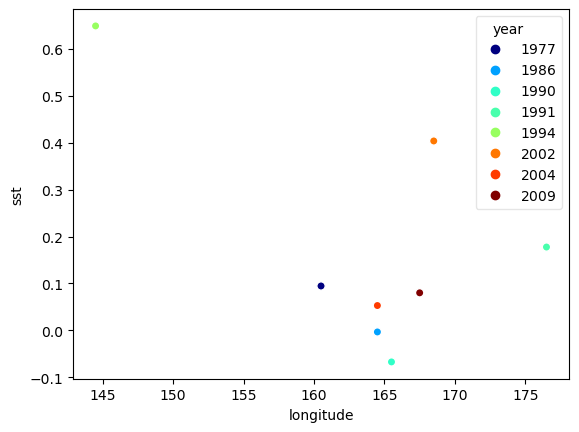

In [100]:
new1.plot.scatter(x = 'longitude', y = "sst", hue = "year", add_legend=True, add_colorbar=False, cmap = "jet")

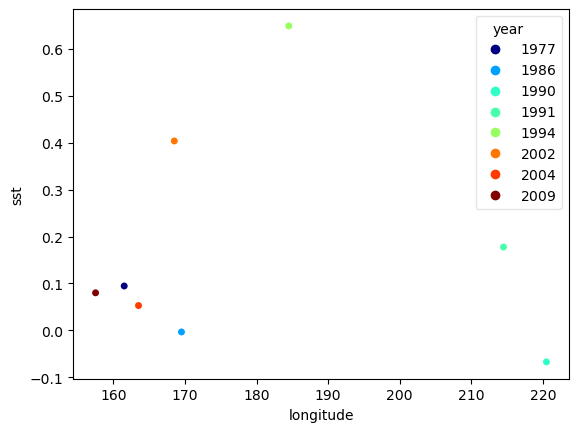

In [101]:
new.plot.scatter(x = 'longitude', y = "sst", hue = "year", add_legend=True, add_colorbar=False, cmap = "jet")

In [87]:
from scipy.stats import pearsonr

In [88]:
pearsonr(new['sst'].values, new['longitude'].values)

PearsonRResult(statistic=0.8332690232412959, pvalue=0.010186802060675373)

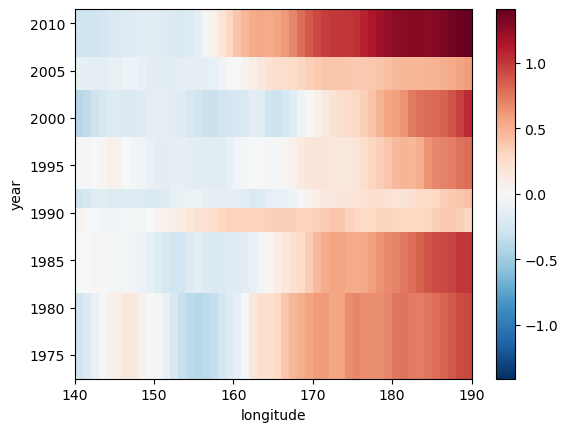

In [89]:
test.plot()

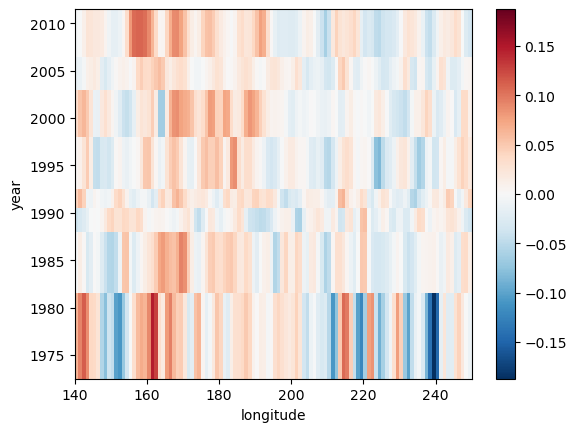

In [79]:
zonal_gradient_da.plot()

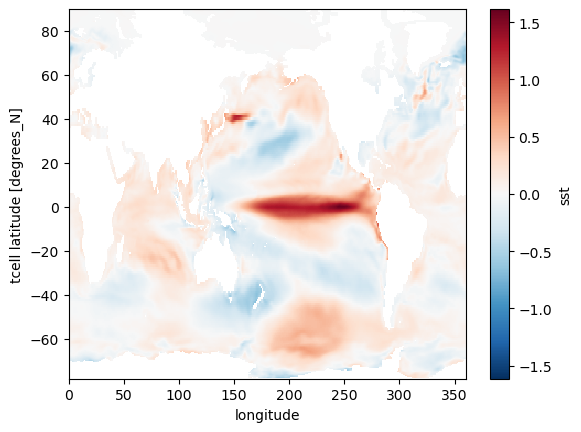

In [178]:
SST_anom.where(SST_anom.year == WP).mean("year").plot()

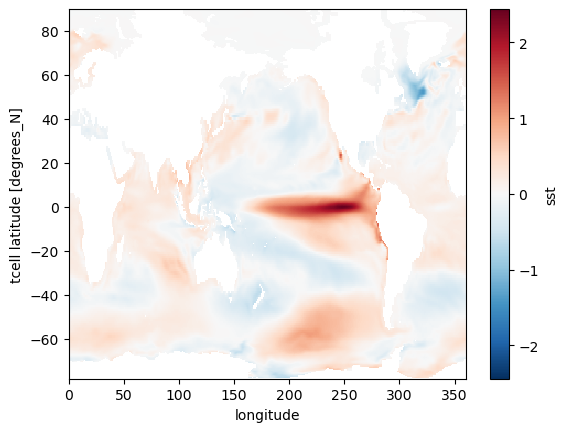

In [179]:
SST_anom.where(SST_anom.year == CT).mean("year").plot()

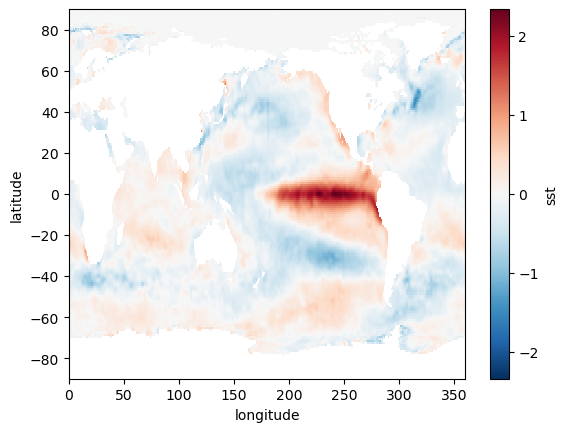

In [112]:
SST_anom.where(SST_anom.year == EP).mean("year").plot()

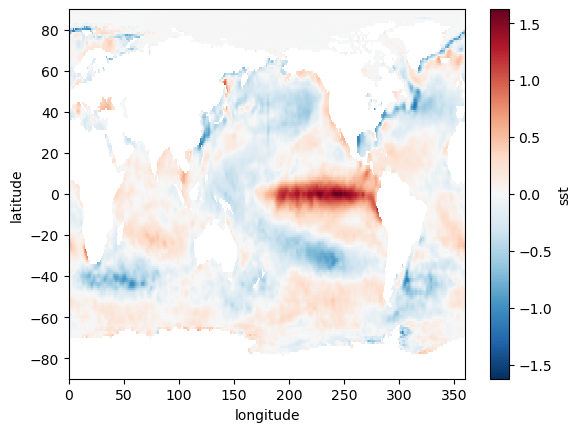

In [113]:
SST_anom.where(SST_anom.year == EPI).mean("year").plot()

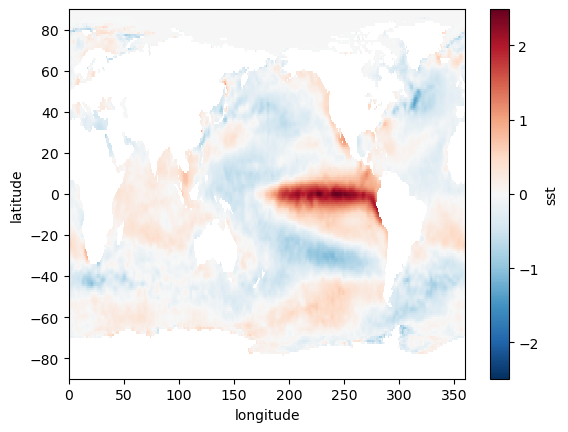

In [114]:
SST_anom.where(SST_anom.year == CT).mean("year").plot()

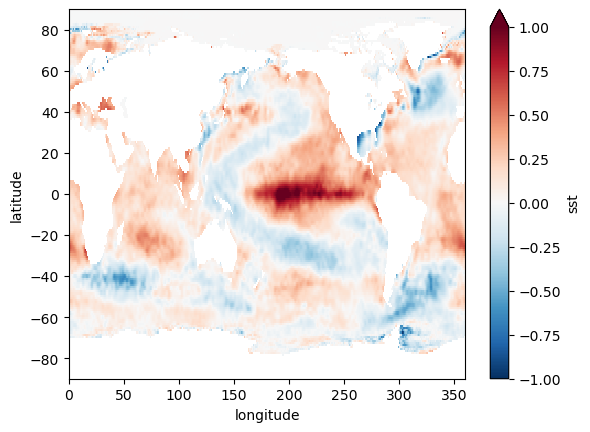

In [290]:
SST_anom.where(SST_anom.year == CP).mean("year").plot(vmin =-1)

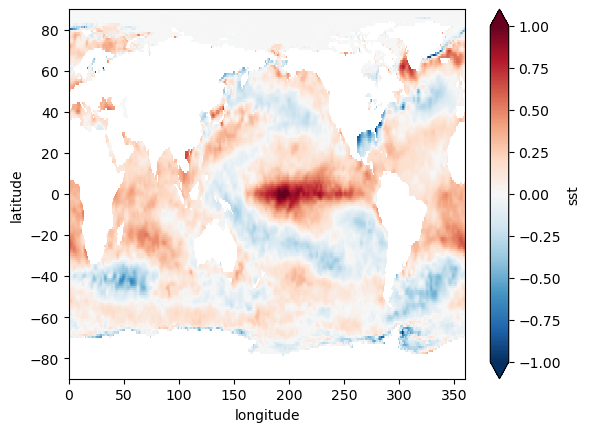

In [291]:
SST_anom.where(SST_anom.year == CPI).mean("year").plot(vmin =-1)

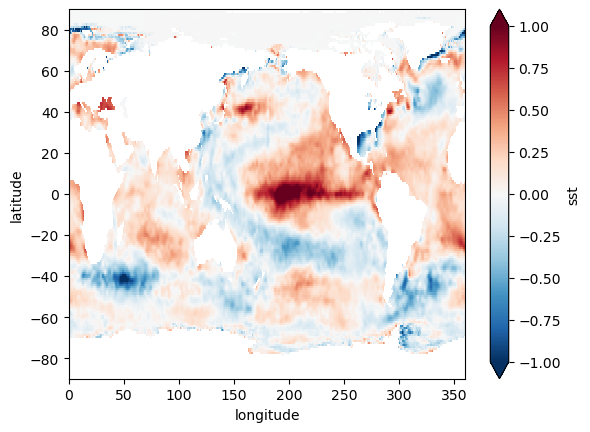

In [292]:
SST_anom.where(SST_anom.year == WP).mean("year").plot(vmin = -1)

In [ ]:
#apply butterworth filtr on SST 6-120 months